# Counterstrike Eco Round Win Analysis

Randy Perkins<br />
CMSC320<br />
Final Project<br />
May 10 2020

## Table of contents
* [Introduction](#Intro)

* [Data](#Data)
* [Exploratory Data Analysis](#Eda)
* [Hypothesis Testing](#Hypothesis)
* [Reflection and concerns about the data](#Reflect)

## Introduction <a class="anchor" id="Intro"></a>

Counterstrike: Global Offensive (CS:GO) is a 5 vs 5 multiplayer online shooter where there are two teams: terrorists and counter terrorists. The goal of the terrorists are to detonate an explosive device and the goal of the counter terrorists is to stop the terrorists from detonating that device. The terrorists win a round by either eliminating all counter terrorists or successfully planting and detonating the device before a pre set timer runs out. the counter terrorists win a round by either eliminating all terrorists before the device is planted, or defusing the explosive device.

Counterstrike has this conception of an "economy". Every time a player eliminates someone, defuses/plants an explosive device, or wins/loses a round that player gets some amount of credits. Both teams can purchase weapons, armor, utility, and grenades at the beginning of each round with the credits they've accumlated in the rounds prior. 

Lastly, there is a term nammed "ECO round" for when one team loses the previous round and has insuffencient credits to buy approprate weapons. This round is a significant disadvantange for the team on the eco and requires clever tactics to win.

In this analysis we will look at the how the use of high explosive grenades in ECO rounds by the on the ECO impact that team's ability to win that round. 


<img src="csgo.jpg">

## Data<a class="anchor" id="Data"></a>

We begin by importing a Python package to help load and wrangle the data
* <a href="https://pandas.pydata.org/"> pandas</a>: an open source data analysis and manipulation tool to view and edit relational data


In [1]:
import pandas as pd

### Counterstrike Data
The Counterstrike data is gathered from kaggle, a machine learning and data science community with resources for data science (<a href = "https://www.kaggle.com/skihikingkevin/csgo-matchmaking-damage">CS:GO Competitive  Data</a>) </br >

The  dataset as well as the grenade damage dataset is displayed in comma-separated values (CSV) format. We will use Pandas `read_csv` function to load these csv files in a workable pandas dataframe and display the dataframe with `head`.
 

In [2]:
demos_part_1 = pd.read_csv("../esea_meta_demos.part1.csv")
demos_part_2 = pd.read_csv("../esea_meta_demos.part2.csv")
grenades = pd.read_csv("../esea_master_grenades_demos_p1.csv", nrows=100000) # reading 100,000 entries
demos_part_1.sample(n=100).head()

,file,map,round,start_seconds,end_seconds,winner_team,winner_side,round_type,ct_eq_val,t_eq_val
41353,esea_match_13782357.dem,de_mirage,10,1003.9550,1103.3440,Team 1,CounterTerrorist,ECO,25900,9550
136075,esea_match_13788027.dem,de_cache,8,738.2306,818.1949,Team 2,Terrorist,ECO,4750,17400
41436,esea_match_13782363.dem,de_inferno,1,131.9758,237.2967,Team 2,Terrorist,PISTOL_ROUND,4100,2950
73007,esea_match_13784241.dem,de_inferno,21,1830.0080,1905.6930,Team 1,Terrorist,ECO,30750,5950
213365,esea_match_13792824.dem,de_cache,9,880.0567,1031.9760,Team 2,Terrorist,ECO,33900,4450


demos_part_2 is an extention of demos_part_1, so we want to combine both of the dataframes with pandas `concat` function:

In [3]:
dataframes = [demos_part_1, demos_part_2]
demos_concat = pd.concat(dataframes)
demos = demos_concat

Demos and grenades give us a lot of usful information about when the round started, when it ended, the grenade location, etc. Some of this information we wont need for this analysis so we can remove it by subsetting our dataframes:

In [4]:
demos = demos[['file','round','winner_side','round_type','ct_eq_val','t_eq_val']]
grenades = grenades[['file','round','att_side','nade']]

Next, we want to filter out rounds that were only eco rounds. We can do some data wrangling to filter our demos datafrane to only feature this with `query`

In [5]:
demos = demos.query("round_type=='ECO'")
demos.head()

,file,round,winner_side,round_type,ct_eq_val,t_eq_val
1,esea_match_13770997.dem,2,Terrorist,ECO,6300,19400
4,esea_match_13770997.dem,5,CounterTerrorist,ECO,5400,20550
6,esea_match_13770997.dem,7,Terrorist,ECO,3200,25300
7,esea_match_13770997.dem,8,CounterTerrorist,ECO,4850,27600
9,esea_match_13770997.dem,10,CounterTerrorist,ECO,32950,9950


Simillarly, we can filter the grenades dataset to feature rounds that high explosive grenades were thrown

In [6]:
grenades = grenades.query("nade=='HE'")
grenades.head()

,file,round,att_side,nade
1,esea_match_13770997.dem,2,Terrorist,HE
2,esea_match_13770997.dem,2,CounterTerrorist,HE
3,esea_match_13770997.dem,2,CounterTerrorist,HE
7,esea_match_13770997.dem,2,Terrorist,HE
9,esea_match_13770997.dem,3,Terrorist,HE


Now, we can combine the demos dataframe with the grenades dataframe to feature eco rounds where explosive grenades were and were not thrown. we can join two dataframes with pandas `merge` function. This is simillar to the SQL construct of of join, in this case it would be a left outer join

In [7]:
df = pd.merge(demos,grenades, how = 'left', left_on=['file','round'], right_on = ['file','round'])
df.head()

,file,round,winner_side,round_type,ct_eq_val,t_eq_val,att_side,nade
0,esea_match_13770997.dem,2,Terrorist,ECO,6300,19400,Terrorist,HE
1,esea_match_13770997.dem,2,Terrorist,ECO,6300,19400,CounterTerrorist,HE
2,esea_match_13770997.dem,2,Terrorist,ECO,6300,19400,CounterTerrorist,HE
3,esea_match_13770997.dem,2,Terrorist,ECO,6300,19400,Terrorist,HE
4,esea_match_13770997.dem,5,CounterTerrorist,ECO,5400,20550,NaN,NaN


### Data transformation

There are only two options a team can be: a terrorist or a counterterrorist. to make things easier for analysis later, lets code the team as a boolean value represented as an integer, 1 for terrorist and 0 for counterterrorist.

we will also create another attribute called `did_eco_win` to denote weather or not the team on the eco won the round as well as an attributed called `did_eco_have_grenade`

we can change the value of a partitual attribute for each entity with pandas `apply` function. `apply` takes a function argument that determines what is being applied to each row 

In [8]:

def did_eco_win(x):
    # If the winner side is 0 (counterterrorist), and countererrorists are on the eco
    if (x['winner_side'] == 0 and x['ct_eq_val'] < x['t_eq_val']):
        return 1
    # If the winner side is 1 (terrorist), and terrorists are on the eco
    if (x['winner_side'] == 1 and x['ct_eq_val'] > x['t_eq_val']):
        return 1
    return 0

def did_eco_have_grenade(x):
    # If the team throwing the grenade is on CounterTerrorist side, and Counterterrorists are on the eco
    if (x['att_side'] == 'CounterTerrorist' and x['ct_eq_val'] < x['t_eq_val']):
        return 1
    #If the team throwing the grenade is on Terrorist side, and Terrorist are on the eco
    if (x['att_side'] == 'Terrorist' and x['ct_eq_val'] > x['t_eq_val']):
        return 1
    return 0
    



df['winner_side'] = df.apply( (lambda x : 0 if 'CounterTerrorist' in x['winner_side'] else 1)  ,axis=1)

df['did_eco_win'] = 0
df['did_eco_win'] = df.apply(did_eco_win, axis = 1)

df['did_eco_have_grenade'] = 0
df['did_eco_have_grenade'] = df.apply(did_eco_have_grenade, axis = 1)

df.head()


,file,round,winner_side,round_type,ct_eq_val,t_eq_val,att_side,nade,did_eco_win,did_eco_have_grenade
0,esea_match_13770997.dem,2,1,ECO,6300,19400,Terrorist,HE,0,0
1,esea_match_13770997.dem,2,1,ECO,6300,19400,CounterTerrorist,HE,0,1
2,esea_match_13770997.dem,2,1,ECO,6300,19400,CounterTerrorist,HE,0,1
3,esea_match_13770997.dem,2,1,ECO,6300,19400,Terrorist,HE,0,0
4,esea_match_13770997.dem,5,0,ECO,5400,20550,NaN,NaN,1,0


Lastly, we remove duplicate rounds by with `grouby` followed by `aggregate`

In [9]:

df = df.groupby(['file','round','winner_side','ct_eq_val','t_eq_val'])
df = df.agg({'did_eco_win' :'max','did_eco_have_grenade' :'max' })
df = df.reset_index()
df.head()



,file,round,winner_side,ct_eq_val,t_eq_val,did_eco_win,did_eco_have_grenade
0,esea_match_13770997.dem,2,1,6300,19400,0,1
1,esea_match_13770997.dem,5,0,5400,20550,1,0
2,esea_match_13770997.dem,7,1,3200,25300,0,0
3,esea_match_13770997.dem,8,0,4850,27600,1,0
4,esea_match_13770997.dem,10,0,32950,9950,0,0


## Exploratory Data Analysis <a class="anchor" id="Eda"></a>

The equipment values of each team are a number that displays how many credits the team's combined guns, grenates, utility, etc are worth. This gives an indication of how much each team spends vs an ECO or while ECO'ing.   

First lets find out exacly which team was the team on ECO

In [10]:

eda = df
eda['eco_eq_val'] = 0
eda['eco_equipment_val'] = df.apply(lambda x : min(x['ct_eq_val'],x['t_eq_val']), axis = 1)

eda['noneco_equipment_val'] = 0
eda['noneco_equipment_val'] = df.apply(lambda x : max(x['ct_eq_val'],x['t_eq_val']), axis = 1)

eda.head()


,file,round,winner_side,ct_eq_val,t_eq_val,did_eco_win,did_eco_have_grenade,eco_eq_val,eco_equipment_val,noneco_equipment_val
0,esea_match_13770997.dem,2,1,6300,19400,0,1,0,6300,19400
1,esea_match_13770997.dem,5,0,5400,20550,1,0,0,5400,20550
2,esea_match_13770997.dem,7,1,3200,25300,0,0,0,3200,25300
3,esea_match_13770997.dem,8,0,4850,27600,1,0,0,4850,27600
4,esea_match_13770997.dem,10,0,32950,9950,0,0,0,9950,32950


We will import <a href="https://plotnine.readthedocs.io/en/stable/"> plotnine</a>, a plotting system for Python to plot our data 

In [11]:
from plotnine import *
import warnings
warnings.filterwarnings("ignore")

Lets use ggplot to plot a histogram in order to show the distribution of eco equitment values

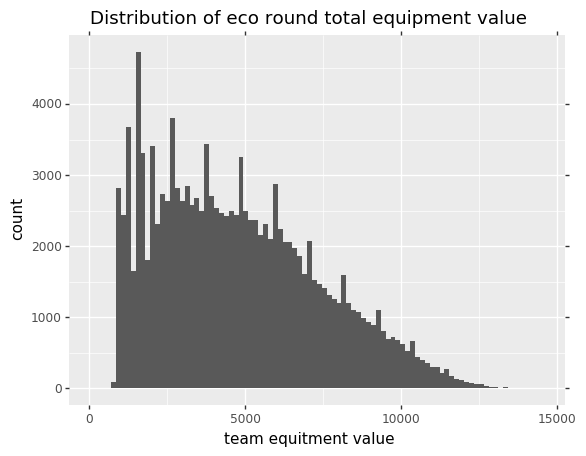

<ggplot: (18602943)>

In [12]:
(ggplot(eda, aes(x='eco_equipment_val')) 
    + geom_histogram()
    + labs(title='Distribution of eco round total equipment value',
          x='team equitment value',
          y='count'))

The plot above shows the equitment value centered around 4500 with a slight spread just past 10,000. This makes sence becuase a team with 5 usps/glocks (the starting weapon) would have a team equipment value of 4000, just under the center of the dataset.

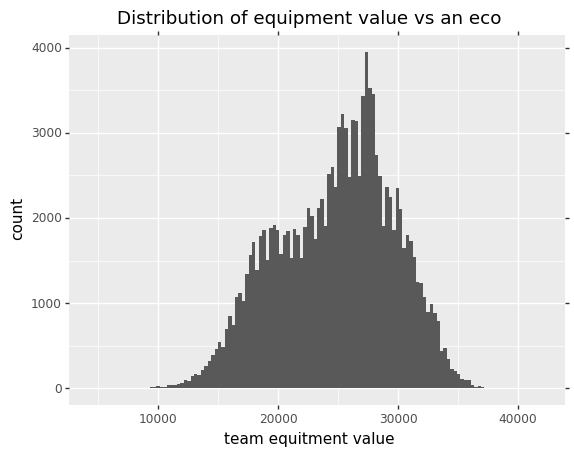

<ggplot: (18608029)>

In [13]:
(ggplot(eda, aes(x='noneco_equipment_val')) 
    + geom_histogram()
    + labs(title='Distribution of equipment value vs an eco',
              x='team equitment value',
              y='count'))

The plot above shows the equipment value centered at around 20,500, it'd be interesting to see this distribution vs the typical distibution of equitment value

Lets plot the typical distribution:

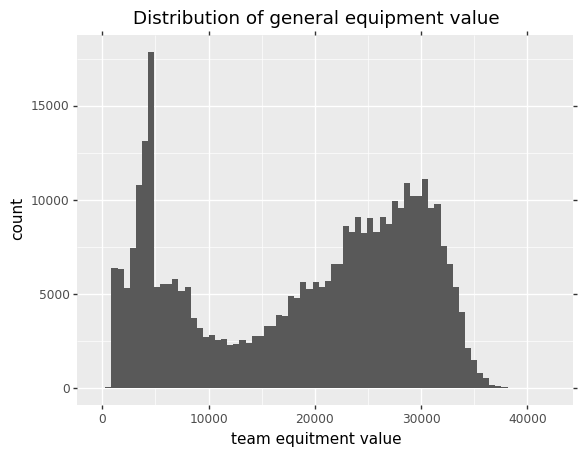

<ggplot: (18745183)>

In [14]:
(ggplot(demos_concat, aes(x='ct_eq_val')) 
    + geom_histogram()
    + labs(title='Distribution of general equipment value',
              x='team equitment value',
              y='count'))

The left hand of the above plot probably refers to the eco rounds/pistol rounds where little to no credits are spent. The right hand probably refers to a typical gun round 

## Hypothesis Testing <a class="anchor" id="Hypothesis"></a>

In this experiment we will be looking at whether using high explosive grenades during an ECO round increases the likelihood for the team on the ECO to win that round.

In order to find this out, we need to first estimate the  Eco round win rate without the use of high explosive grenades 

In [15]:
no_grenades = df.query("did_eco_have_grenade==0")

num_elements = no_grenades.count().tolist()[0]
print("The number of eco rounds without a high explosive grenade thrown is: " + str(num_elements))

no_grenades_win = no_grenades.query("did_eco_win==1")
num_eco_won = no_grenades_win.count().tolist()[0]
print("The number of eco rounds won without a high explosive grenade thrown is: " + str(num_eco_won))

sample_mean_no_grenades =  num_eco_won/num_elements

print("The sample mean for an eco win without a high explosive grenade thrown is : " + str(sample_mean_no_grenades))


The number of eco rounds without a high explosive grenade thrown is: 127895
The number of eco rounds won without a high explosive grenade thrown is: 21560
The sample mean for an eco win without a high explosive grenade thrown is : 0.168575784823488


From the Central limit theorem: given a suffiently large sample size with independent identically distributed samples, the sample mean will approximate the population mean, or the known eco win rate. The sample size for this experiment is 127895, which is sufficent<br />
i.e<br />
$\hat{p_A}$ = 0.16879 ~ ${p_A}$


Now, we can estimate the Eco wound win rate with the use of high explosive grenades

In [16]:
grenades = df.query("did_eco_have_grenade==1")

num_elements = grenades.count().tolist()[0]
print("The number of eco rounds with a high explosive grenade thrown is: " + str(num_elements))

grenades_win = grenades.query("did_eco_win==1")
num_eco_won = grenades_win.count().tolist()[0]
print("The number of eco rounds won with a high explosive grenade thrown is: " + str(num_eco_won))

sample_mean_grenades =  num_eco_won/num_elements

print("The sample mean for an eco win with a high explosive grenade thrown is : " + str(sample_mean_grenades))

The number of eco rounds with a high explosive grenade thrown is: 718
The number of eco rounds won with a high explosive grenade thrown is: 152
The sample mean for an eco win with a high explosive grenade thrown is : 0.2116991643454039


$\hat{p_B}$ = 21170

Now, lets state our null hypothesis we are testing for:<br /> <br />
${H_0}$: Using a high explosive grenade during an ECO round will not improve the likelihood of the ECO team winning that round<br />

for this experiment we will use rejection level $\alpha = 0.05$

To Test this, we need to derive the Expected value for the population mean and derive the population variance:<br /><br />
${E[\bar{X}] = E[(1/n)\sum_{i=1}^{n}X_i]}$<br />
${ = (1/n)E[\sum_{i=1}^{n}X_i]}$<br />
${ = (1/n)(np_A)}$<br />
${ = p_A}$
<br /> <br />
$var(\bar{X})$ = $1/n^2(var(\sum{}x))$
<br />= $1/n^2 np(1-p)$ 
<br />= $ (p(1-p))/n$
<br />

From these derivations we can deduce:<br />
$E[\bar{X}] = 0.16879$<br />
$var(\bar{X}) = (0.16879(1-0.16879)) / 718 = .000195$
<br />
<br />
<br />
We can import 2 libraries to test our null hypothesis:
* <a href="https://www.scipy.org/"> scipy</a>: Python-based ecosystem of open-source software for mathematics, science, and engineering
* <a href="https://docs.python.org/3/library/math.html"> math </a>


In [17]:
from scipy import stats
from scipy.stats import norm
import math

We wil test our null hypothesis using the cumlutive distribution function

In [18]:
standard_devation = math.sqrt((0.16879*(1-0.16879)) / 718)
expected_value_mean = 0.16879
p_b = sample_mean_grenades
p = 1 - norm.cdf(p_b,expected_value_mean,standard_devation)
p

0.001071683632650977

We do  reject the null hypothesis here, because P($\bar{X}$ >= $p_b$) ~ .00107, which is below our rejection maximum, .05
<br /> 

With 95% confidence, we can say that using a High explosive grenade while on an ECO will improve the chances of winning that round

## Conclusion <a class="anchor" id="Reflect"></a>

<b>Interpreting the results</b><br />
intuitively, it would make sense as to why using high explosive grenades would improve the likelihood of winning a round. Its an easy way to deal damage without having to engage in a gunfight, and a pistol would lose that fight 9 times out of 10. However, its important that we quantify this difference and ensure that our intuition isnt leading us astray. I can just as easily envision a scenerio where buying HE grenades would lower the chances. stacking HE grenades on ECO rounds can lead to unfavorable outcomes. For example on dust 2, grenade stacking long doors while the enemy rushes B or holds for a push outside of long doors. This scenerio comes at the detrement of the team buying the grenades, because it only hurts them in that case. This is why hypothesis testing and data analysis is important, so we can draw conclusions based on concrete data, rather than intuition.


<b>concerns about the data</b><br />
The data gathered was from Semi professional ESEA Advanced games. These semi professional games can vary significaly depending on the skill level of the teams and can be  unpredictible. This data is by and large the most readily avaible and the breadth of data available leads for a more consistent analysis.

What consituded an Eco round vs a force buy was entirely at the discression of the data collector on kaggle.com. It could be the case that some of the force buys would have been considered an eco under different critiera, or vice versa. However, this dataset has over 3,000 downloads and is one of the most popular csgo datasets on kaggle so i trust the critera set by the data collector.